In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Benchmark: Gaussian Linear Uniform

In [3]:
benchmark_name = 'gaussian_linear_uniform'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the gaussian_linear_uniform model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [4]:
coupling_settings = {'dense_args': dict(units=32, activation='relu'), 'dropout_prob': 0.05}
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(InvertibleNetwork(num_params=10, num_coupling_layers=5, coupling_settings=coupling_settings)),
    AmortizedLikelihood(InvertibleNetwork(num_params=10, num_coupling_layers=5, coupling_settings=coupling_settings))
)

In [5]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1,
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time on GPU approx. 6min 14s

In [6]:
# EPOCHS = 50
# SIMULATION_BUDGET = 10000
# BATCH_SIZE = 64
# N_VAL = 300

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [20]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

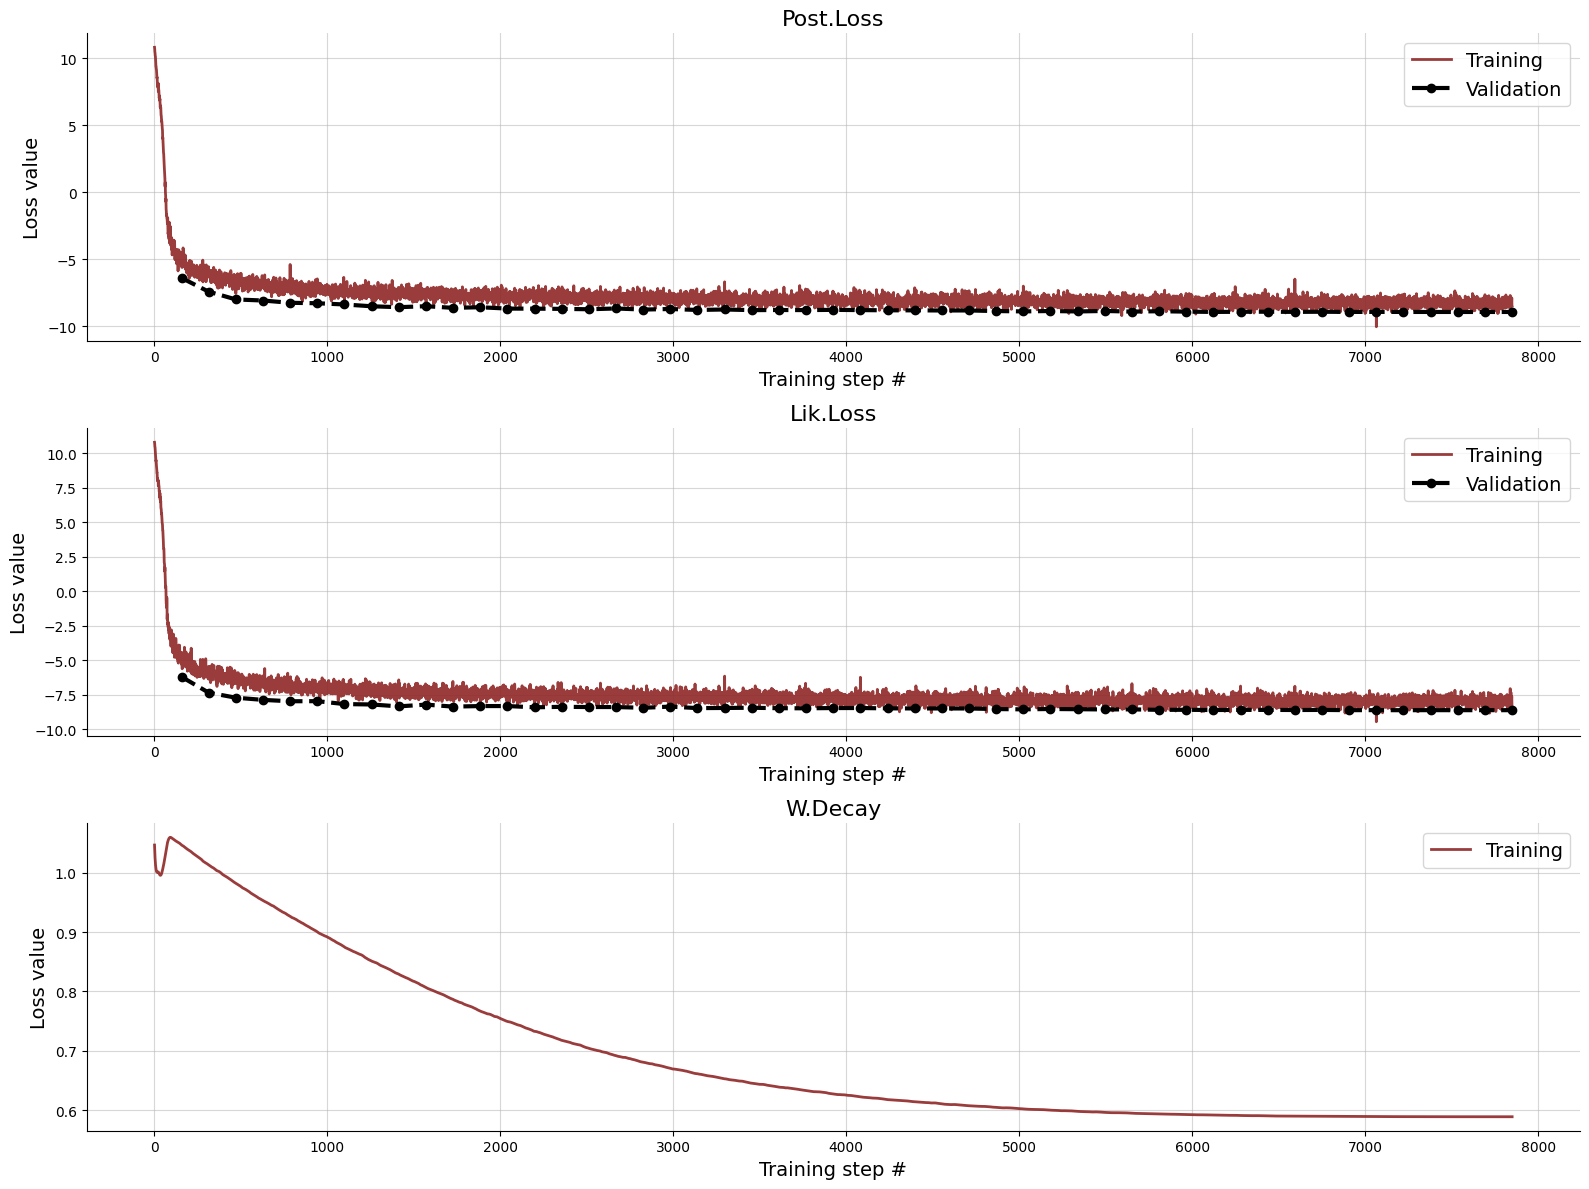

In [8]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [9]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [10]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

### Calibration

#### ECDF Difference (Stacked)

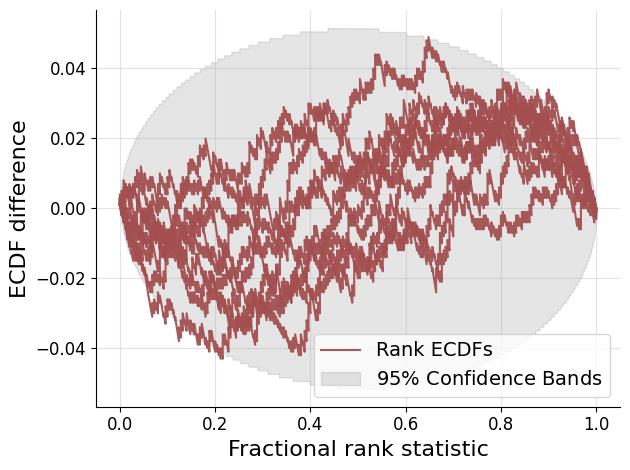

In [11]:
# Posterior given simulator outputs
f = plot_sbc_ecdf(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

These will be the figures for the paper.

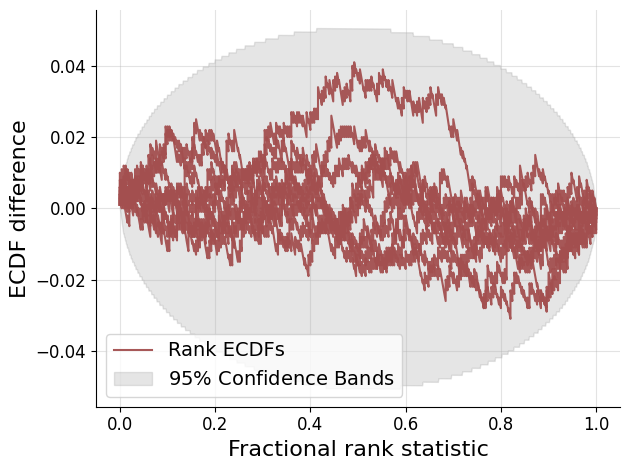

In [13]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True, difference=True)

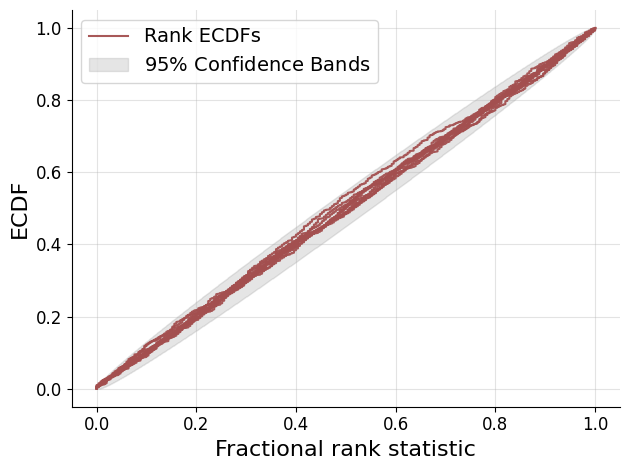

In [14]:
# Posterior given surrogate outputs
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), stacked=True)

#### Individual ECDF Plots

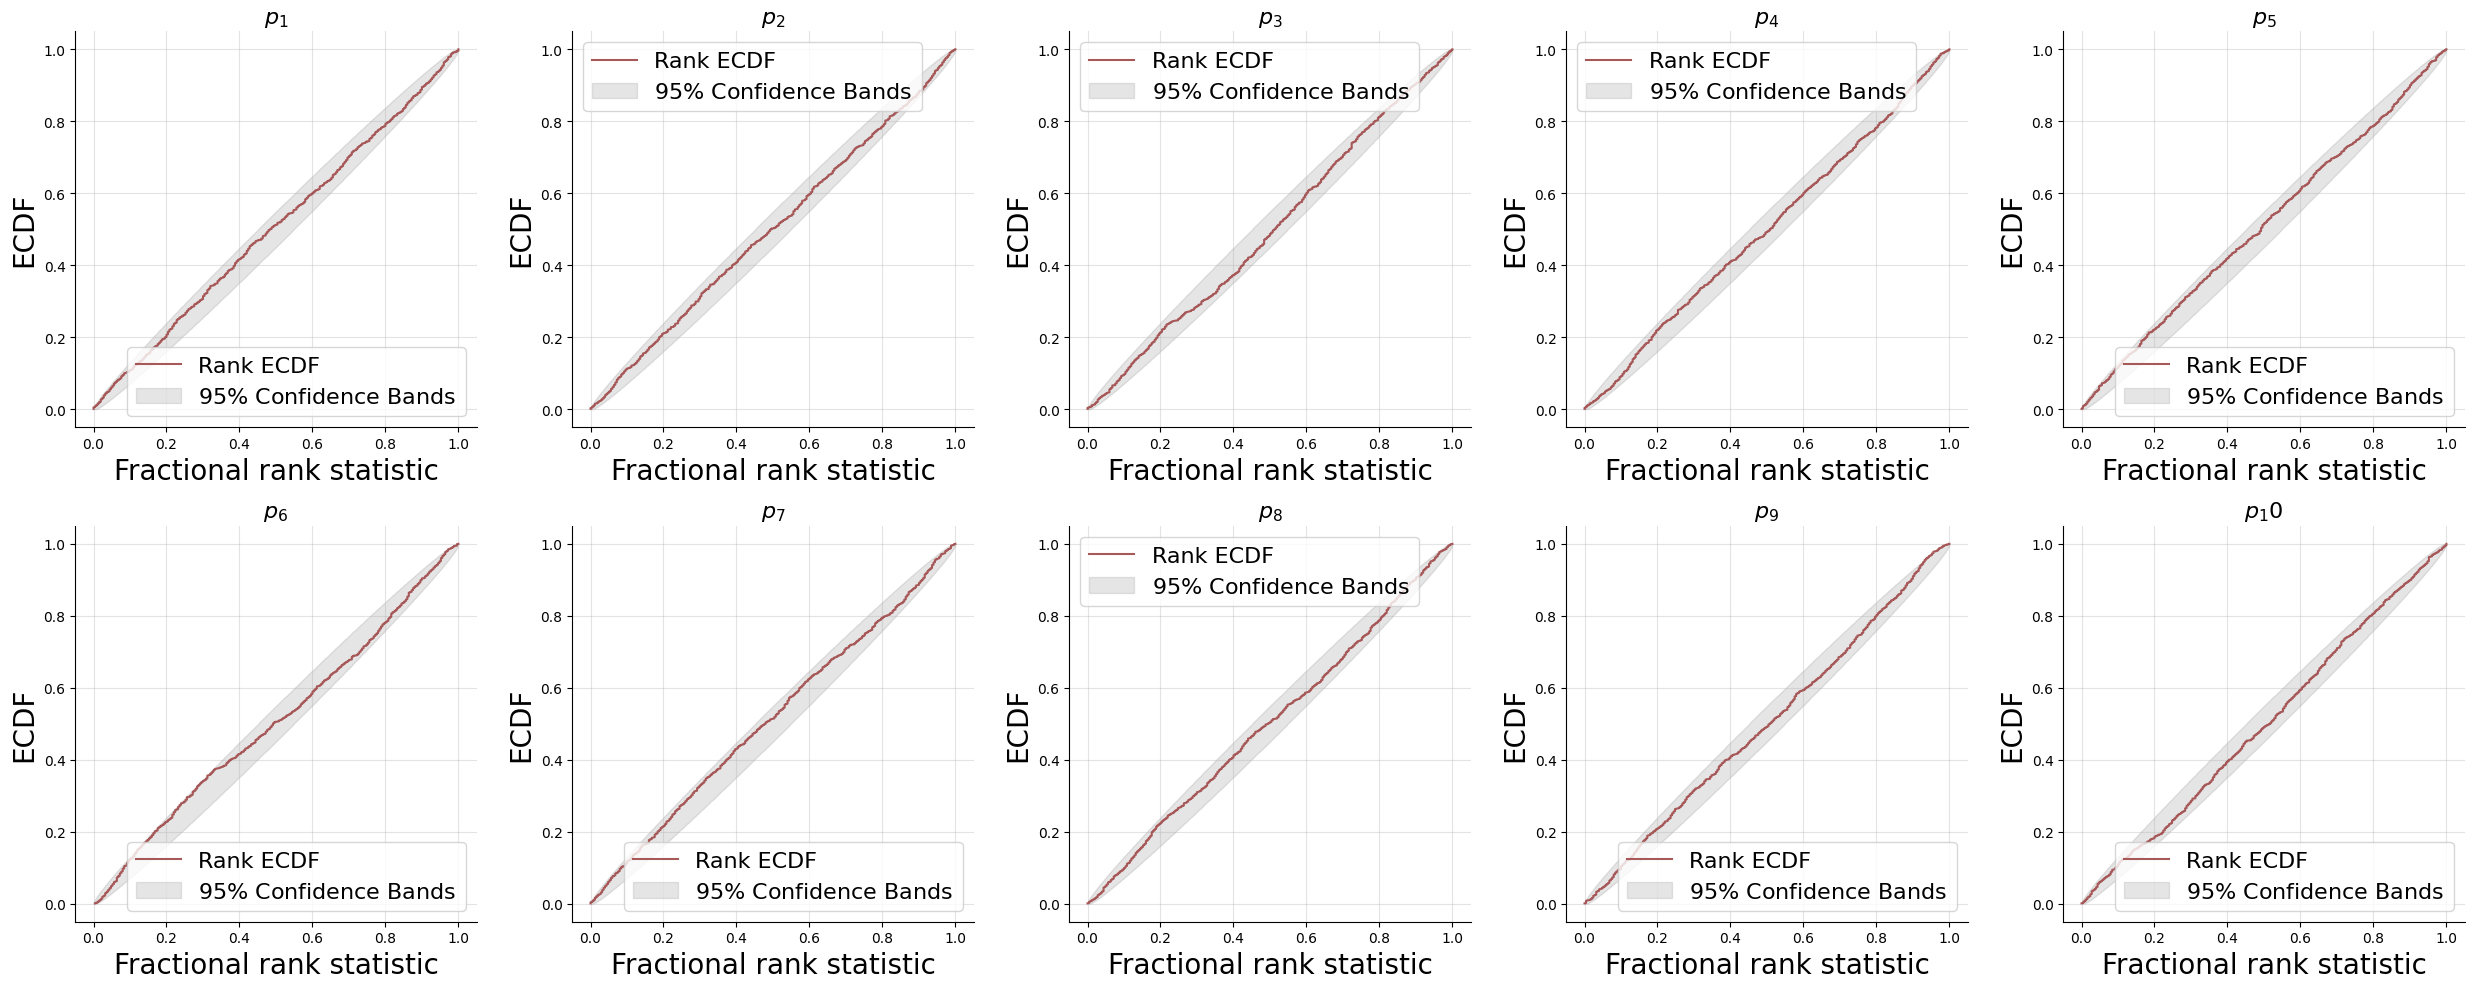

In [14]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                  label_fontsize=20, legend_fontsize=16)

#### Recovery

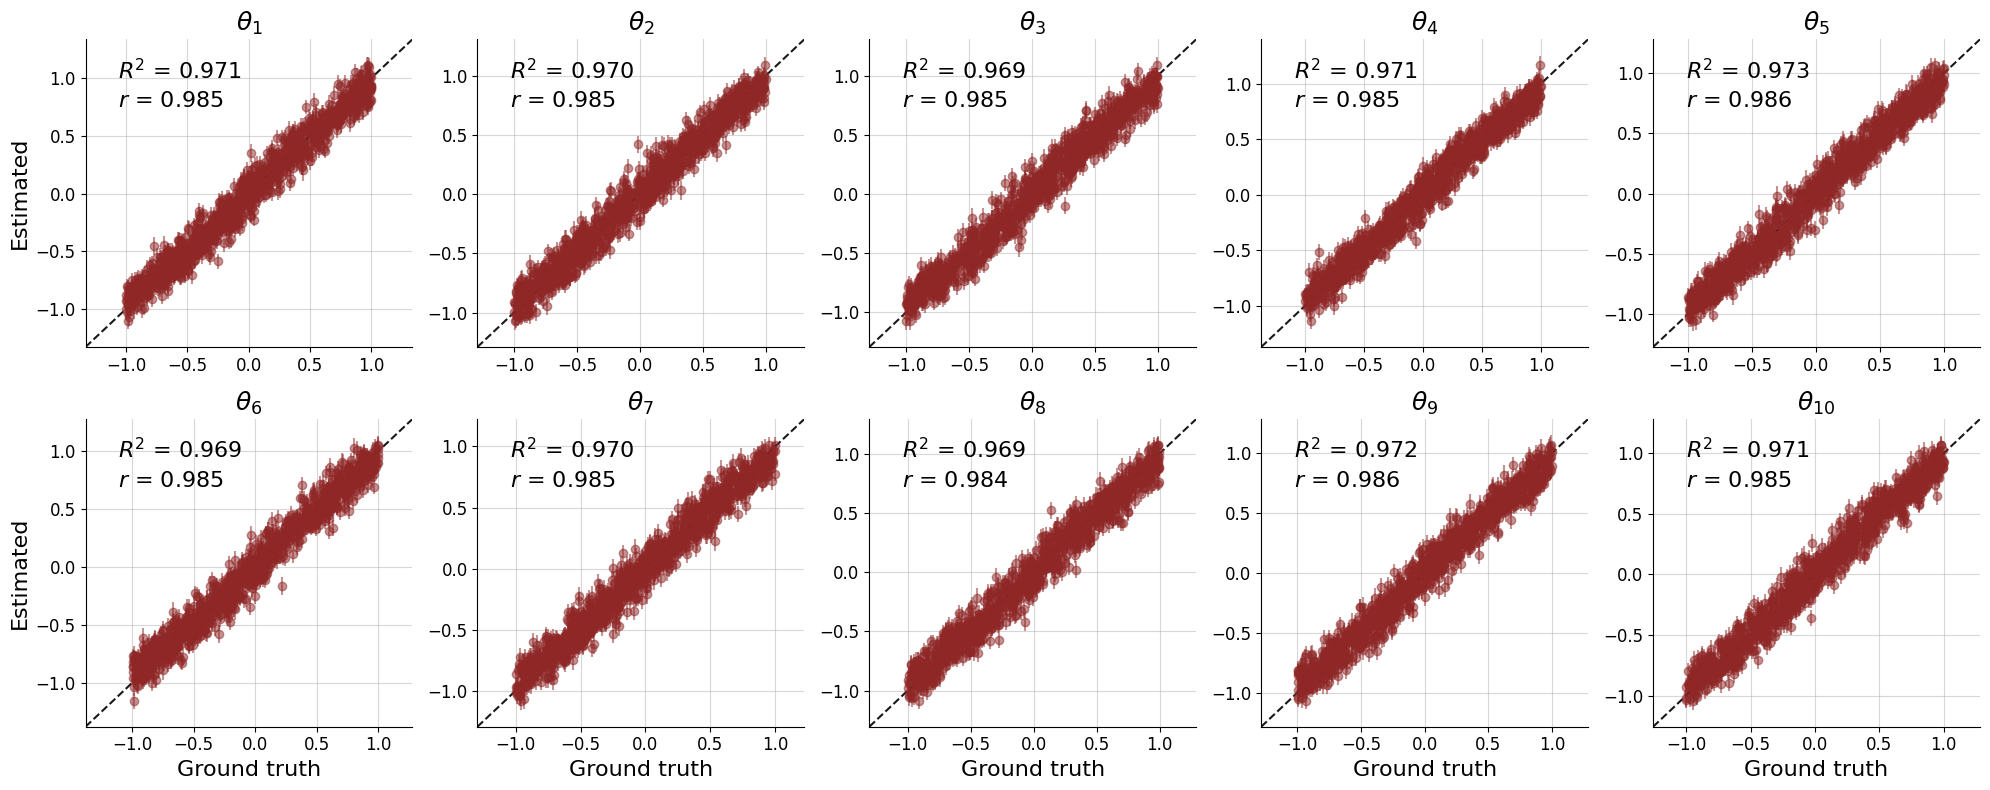

In [15]:
f = plot_recovery(post_samples, prior_samples)

# Appendix Plots

In [16]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

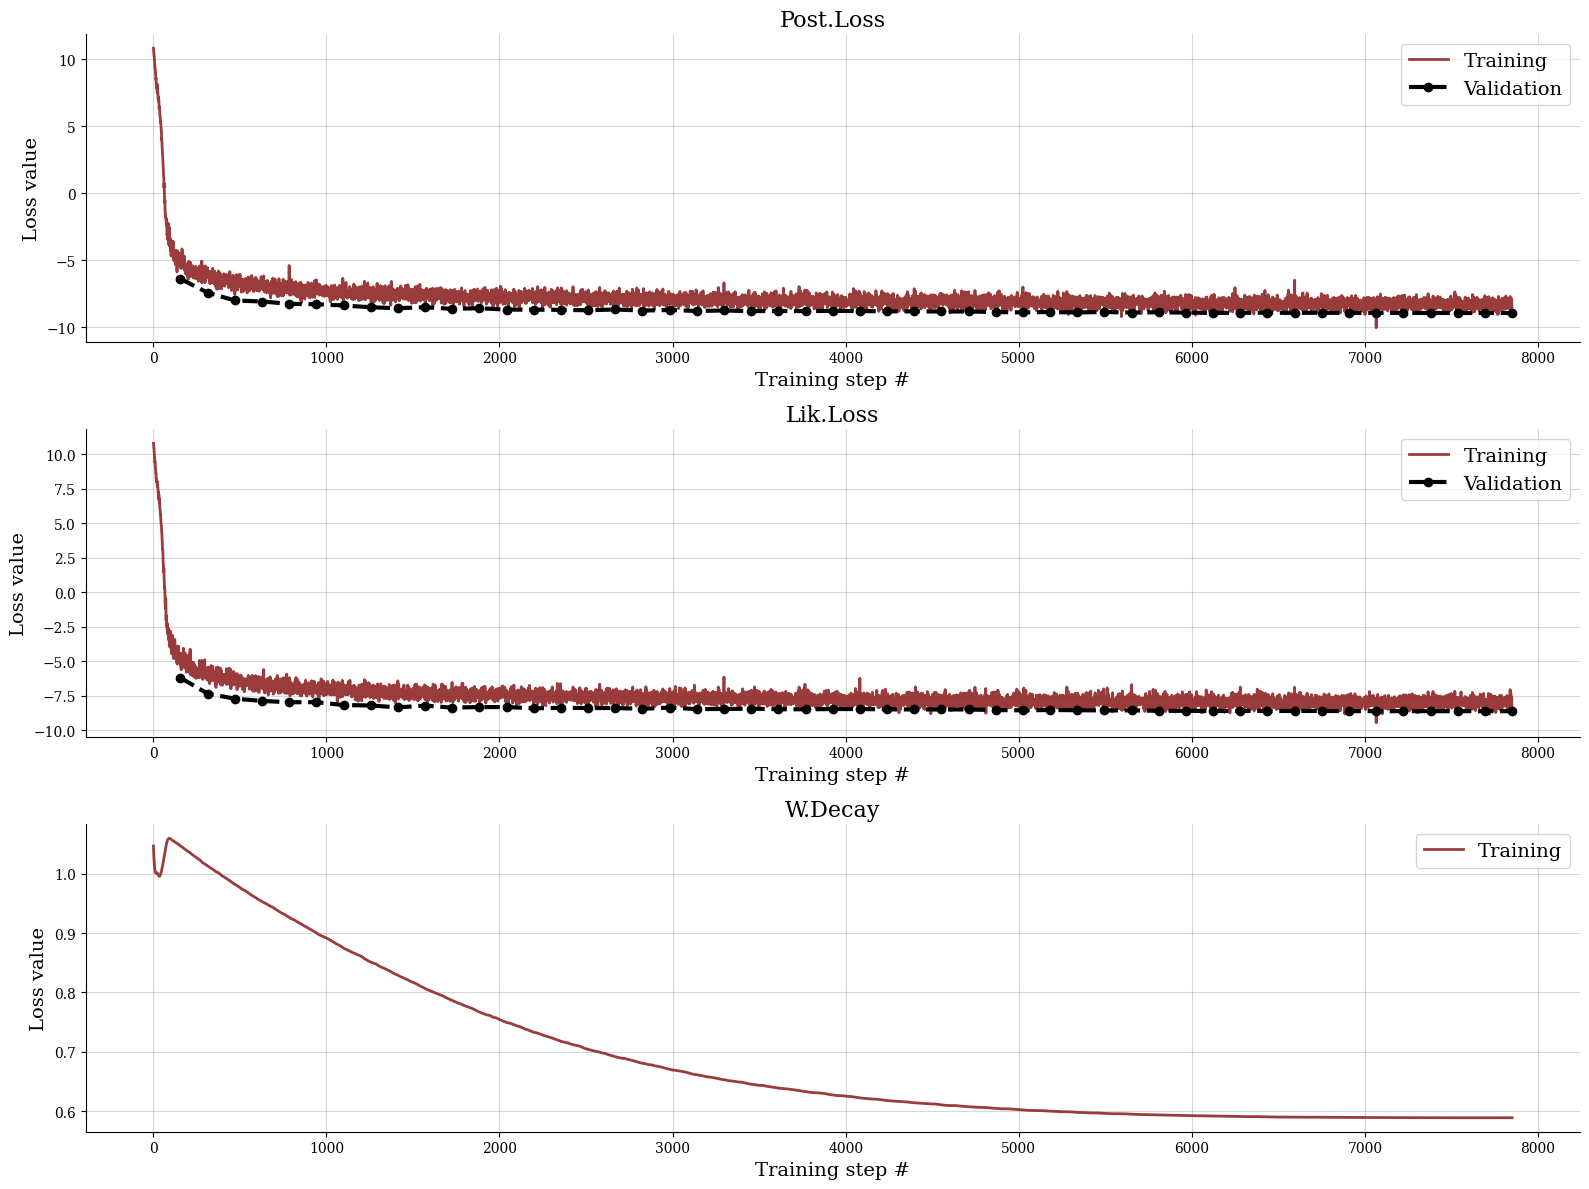

In [17]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

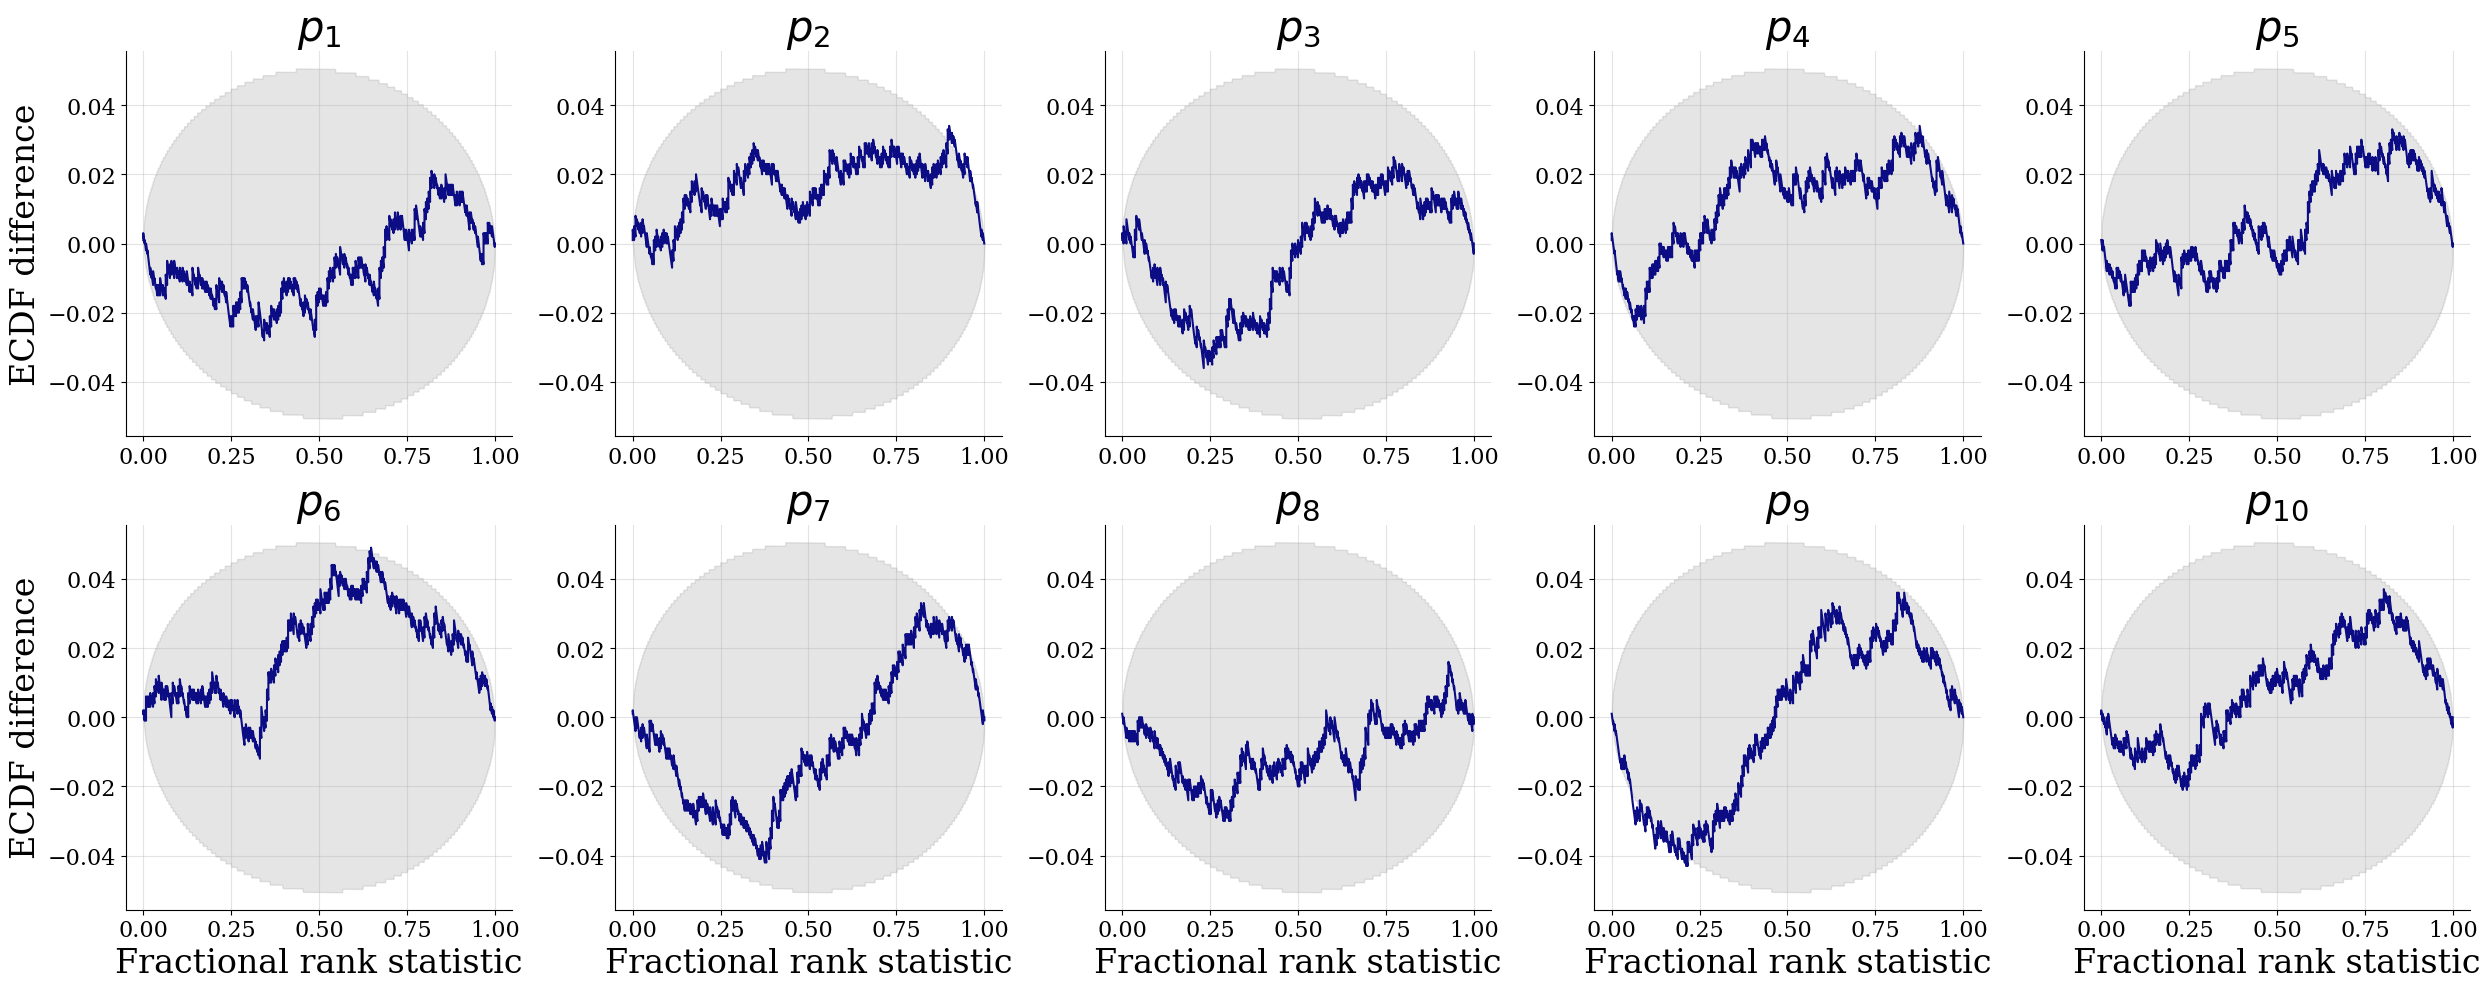

In [18]:
f = plot_sbc_ecdf_appendix(post_samples, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#000080' )
plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")

### Joint Calibration

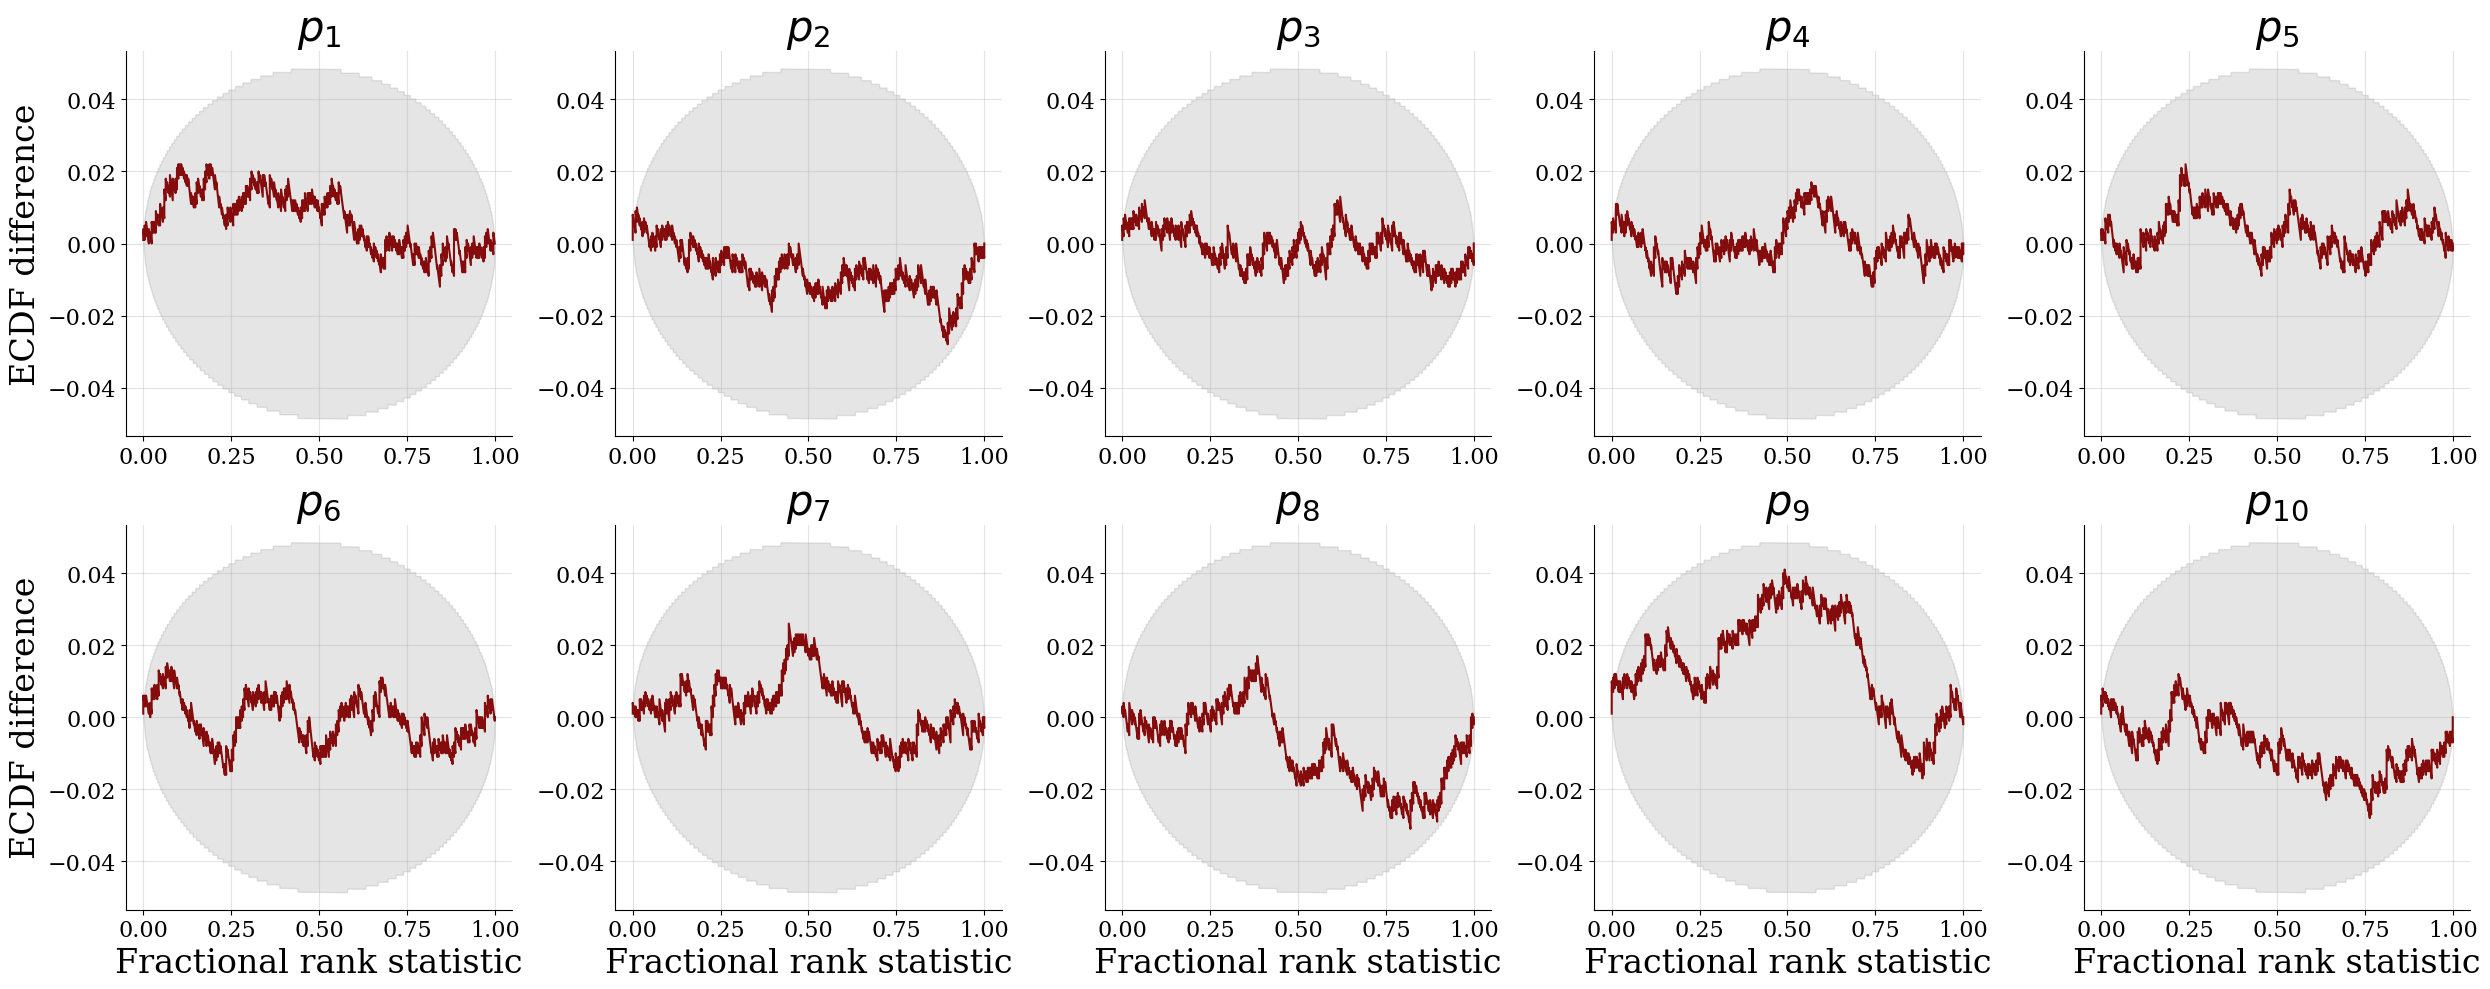

In [19]:
f = plot_sbc_ecdf_appendix(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), 
                           param_names = benchmark.benchmark_info['parameter_names'],
                           label_fontsize=24, legend_fontsize=24, difference=True, rank_ecdf_color = '#800000')
plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi = 300, bbox_inches = "tight")